In [1]:
%load_ext autoreload
%autoreload 2

08:16:17 - INFO: Sampling 8 new images....
699it [01:59,  5.87it/s]


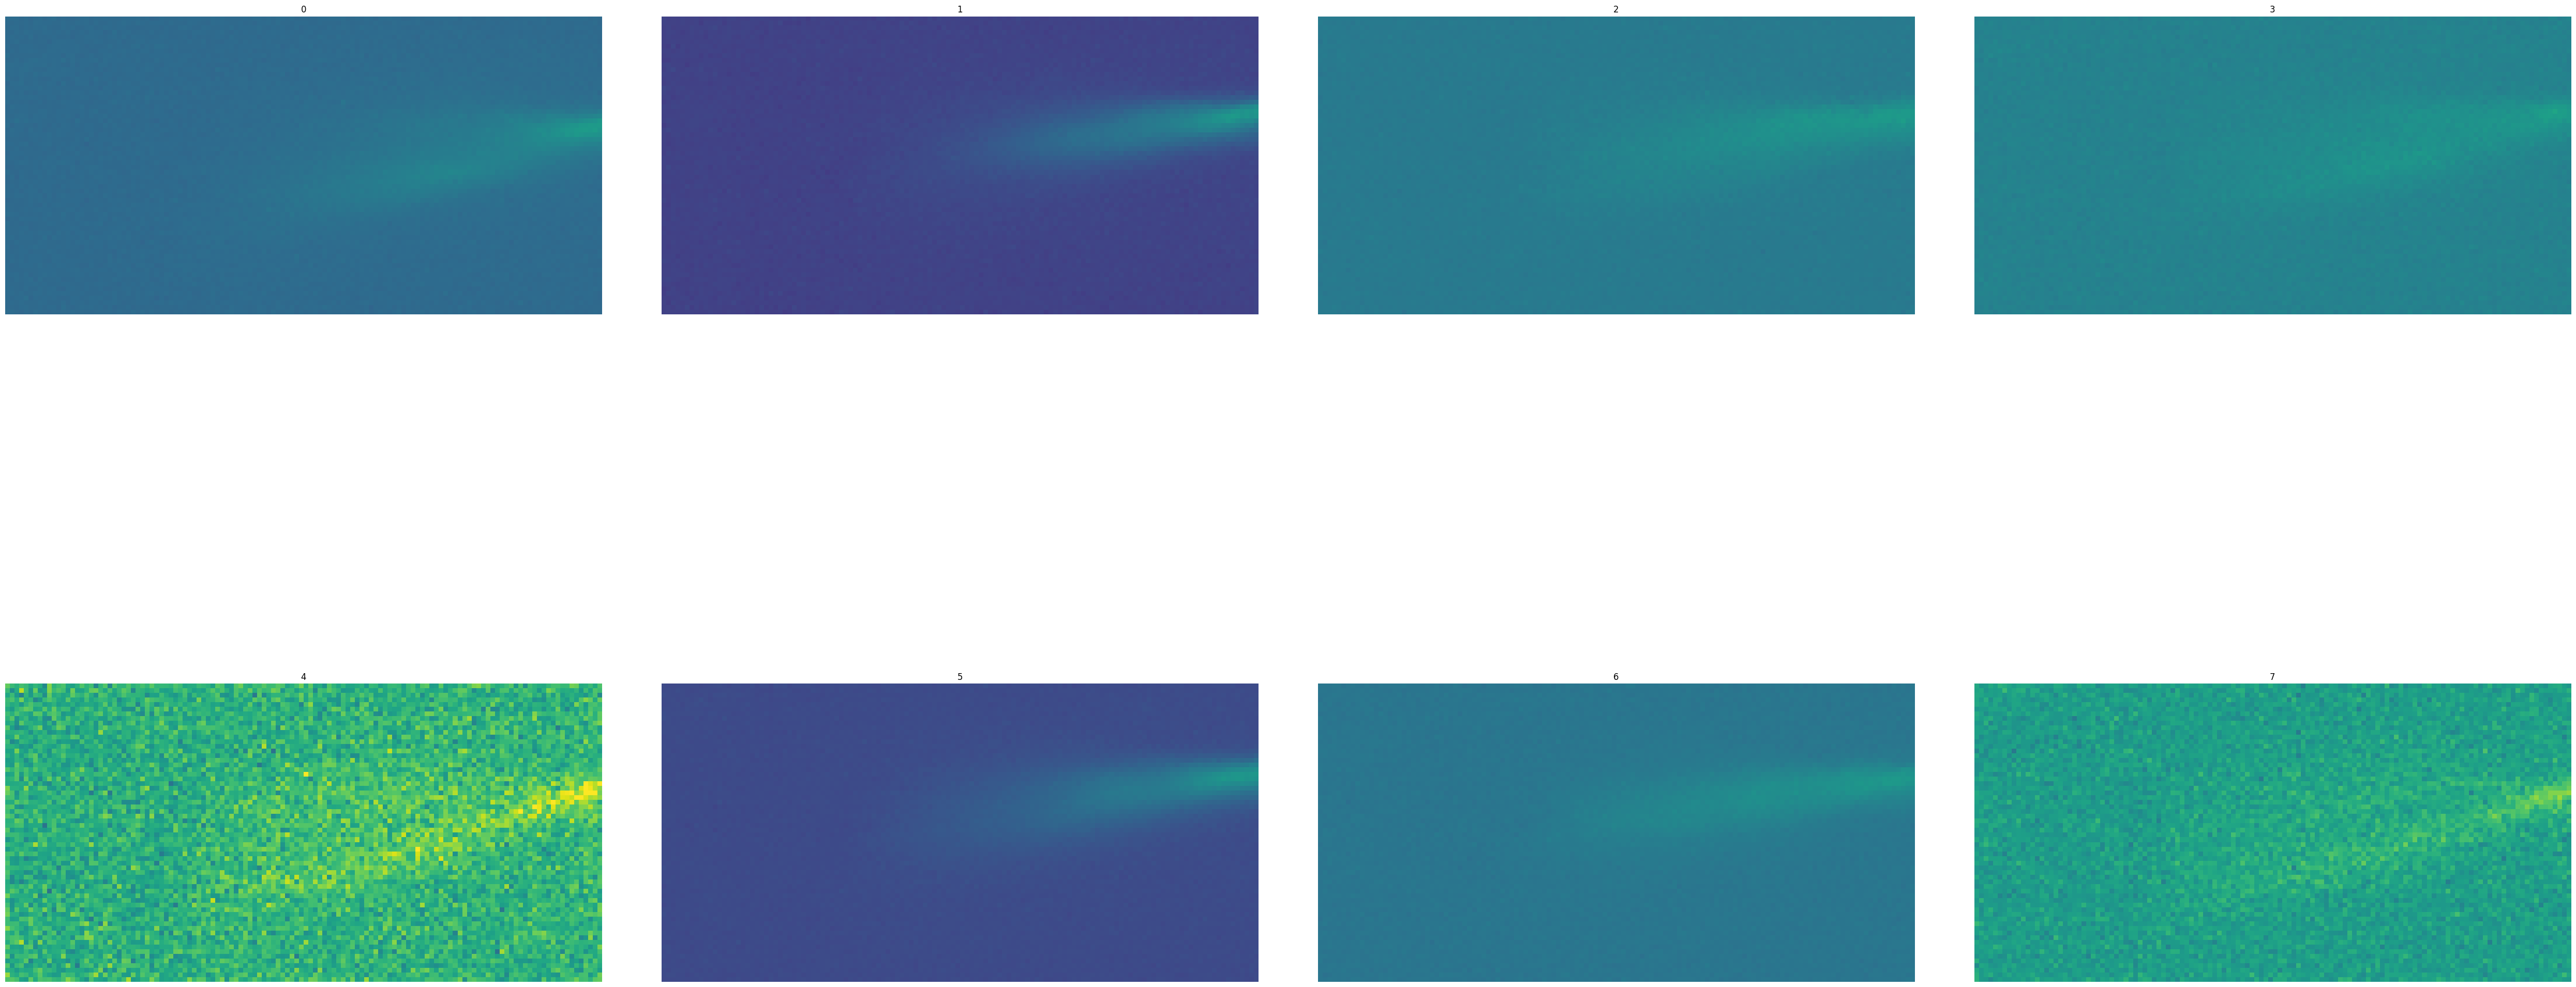

In [7]:
from ddpm_conditional import *
from utils import plot_images, plot_images_from_dir

n = 8
device = "cuda:1"
model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/CFG_noEMA/ema_ckpt.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_width=128, img_height=64, device=device, noise_steps=700)
y = torch.Tensor([13,14,20]).to(device).float().unsqueeze(0)
x = diffusion.sample(model, n, y, cfg_scale=10)
plot_images(x)
save_samples(x)

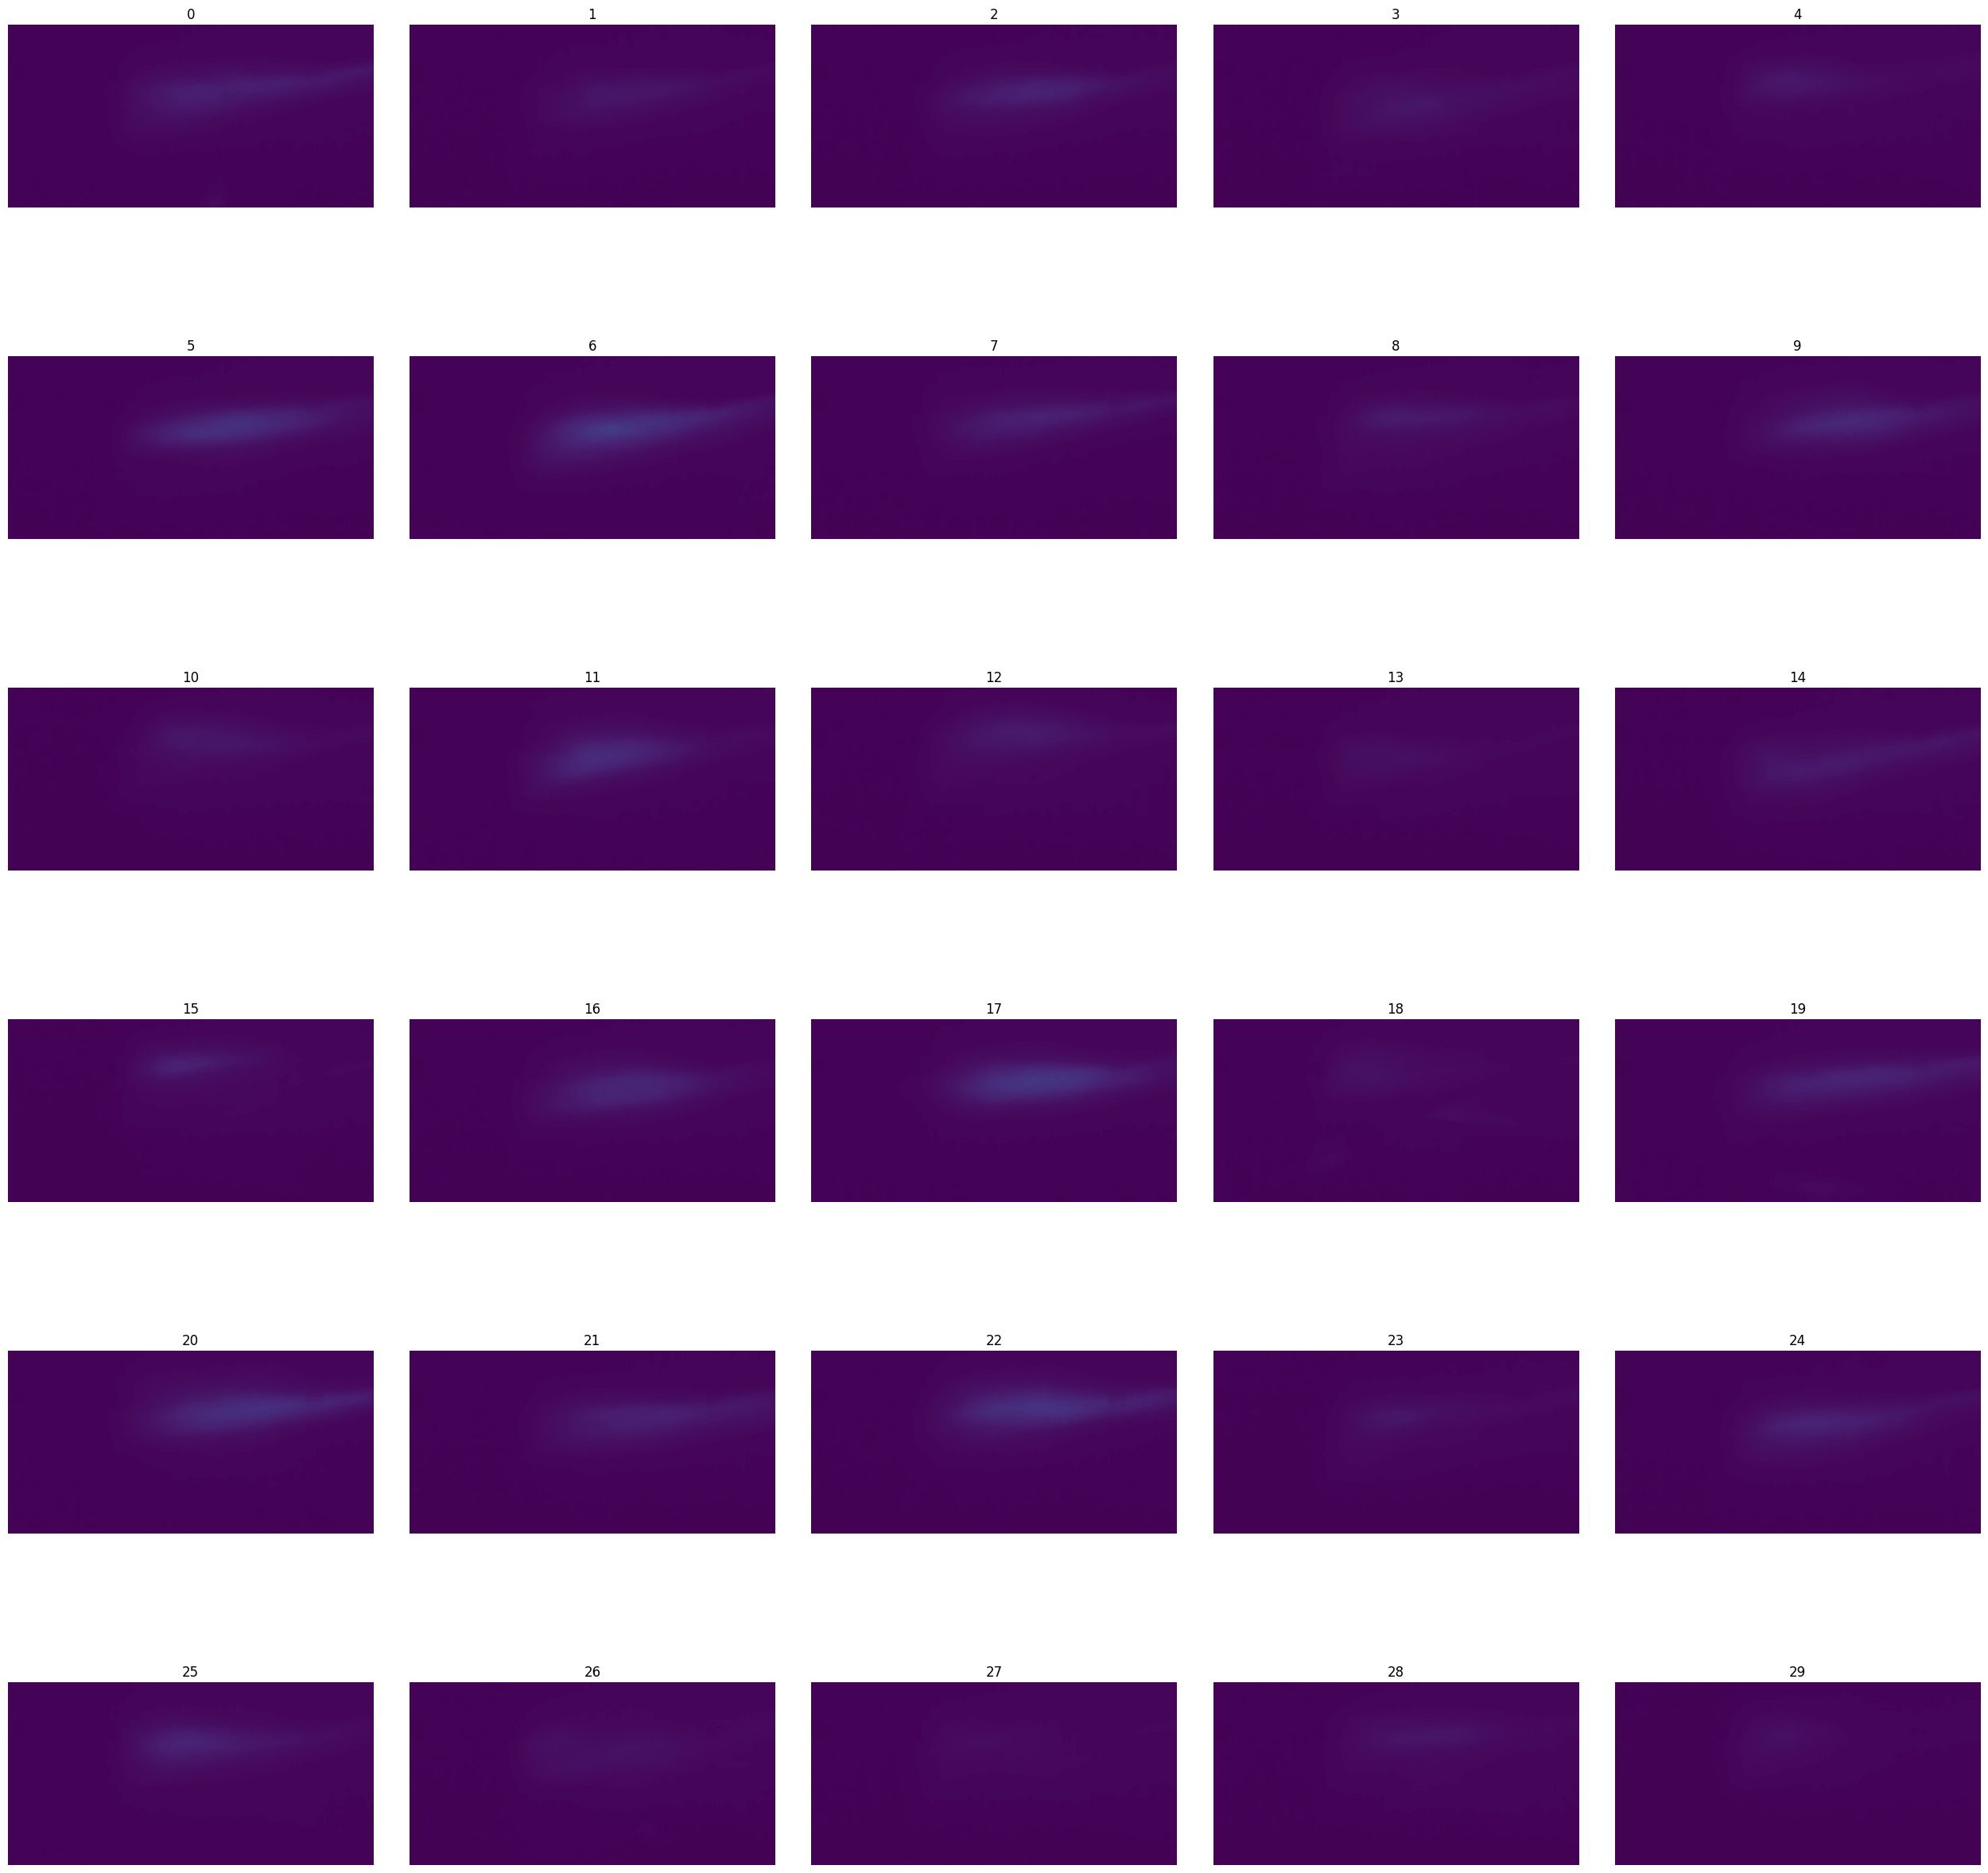

In [4]:
plot_images_from_dir("train/3", 30)